In [13]:
import sys; sys.path.append('..')
import demosaicing as dm
import importlib; importlib.reload(dm)

import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,20)

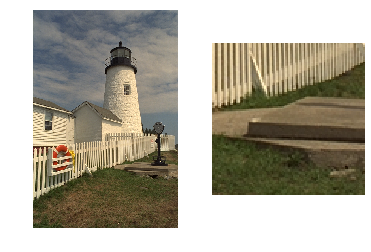

In [2]:
kodak_dir = "../data/kodak/"
kodak = dm.kodak_dataset(kodak_dir)
crop = slice(500,600),slice(300,400)
dm.show_images([kodak[18], kodak[18][crop]], layouts='12', bgr2rgb=True)

In [3]:
interp = {
    'original': kodak[18].copy()
}

## Spatial downsampling

Spatially downsample according to bayer pattern 

$$
B \quad G
$$
$$
G \quad R
$$

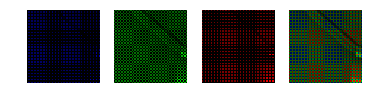

In [4]:
lh = dm.bayer_downsample(kodak[18])
lhc = lh[350:400,200:250,:]
dm.show_images([*list(map(lambda i: dm.color_channel(lhc,i), [0,1,2])), lhc], layouts='14', bgr2rgb=True)

## Performance Metrics

+ MSE 
+ PSNR https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio

In [5]:
downsampled = np.sum(dm.bayer_downsample(kodak[18]), axis=2, dtype=np.uint8)
dm.psnr(kodak[18], cv.cvtColor(downsampled, cv.COLOR_BayerBG2BGR))

38.137495554288336

## OpenCV's demosaic method 

- [reference](https://docs.opencv.org/3.1.0/d7/d1b/group__imgproc__misc.html#gga4e0972be5de079fed4e3a10e24ef5ef0a8945844ab075687f4d4196abe1ce0db4)
    - bilinear
    - variable number of gradients
    - edge-aware

original            	0
opencv_bilinear     	38.137495554288336
opencv_vng          	34.85396172397117
opencv_edge_aware   	38.23507359741863


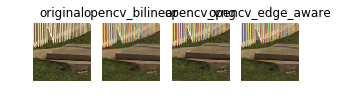

In [6]:
demosaic_opencv = [
    ('opencv_bilinear', cv.COLOR_BayerBG2BGR),
    ('opencv_vng', cv.COLOR_BayerBG2BGR_VNG),
    ('opencv_edge_aware', cv.COLOR_BayerBG2BGR_EA)
]
lh = dm.bayer_downsample(kodak[18])
lh = np.sum(lh, axis=2, dtype=np.uint8)
for k,code in demosaic_opencv:
    interp[k] = cv.cvtColor(lh, code)

for k,img in interp.items():
    psnr = dm.psnr(interp["original"], img)
    print(f'{k:<20}\t{psnr}')

desc, imgs = zip(*list(interp.items()))
dm.show_images([img[(*crop,)] for img in imgs], desc, layouts='15', bgr2rgb=True)

# bilinear interpolation 

+ slides: http://www.dmi.unict.it/~battiato/mm1112/Parte%207.3%20%20-%20Demosaicing.pdf

The interpolated green intensity $G_{i,j}$ is simply the average of its immediate neighbors

$$
G_{i,j} = \frac{1}{4} \left( G_{i-1,j} + G_{i+1,j} + G_{i,j-1} + G_{i,j+1} \right)
$$

Similarly for red/blue intensities. The interpolation proceeds independently within each channel.

We can efficiently implement this method by convolution with 3x3 kernels over each of 3 color channels

$$
K_G = \frac{1}{4} \begin{bmatrix} 0&1&0 \\ 1&4&1 \\ 0&1&0 \end{bmatrix}
\quad\quad
K_R = K_B = \frac{1}{4} \begin{bmatrix} 1&2&1 \\ 2&4&2 \\ 1&2&1 \end{bmatrix}
$$ 
<img src="assets/bilinear_filters.png" alt="drawing" width="400"/>


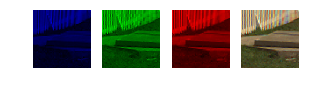

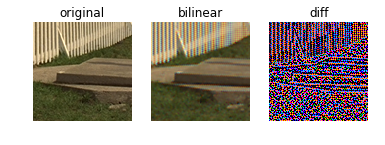

In [7]:
lh = dm.bayer_downsample(kodak[18])
interp["bilinear"] = dm.demosaic_bilinear(lh)
lhc = interp["bilinear"][(*crop,)]
dm.show_images([*list(map(lambda i: dm.color_channel(lhc,i), [0,1,2])),lhc], layouts='15', bgr2rgb=True)
dm.show_images([kodak[18][crop], lhc, kodak[18][crop]-lhc], descriptions=['original','bilinear', 'diff'], layouts='13', bgr2rgb=True)

## Validation over Kodak dataset

In [8]:
demosaic_algos = [
    ('opencv_bilinear',     lambda x: cv.cvtColor(x, cv.COLOR_BayerBG2BGR)),
    ('opencv_vng',          lambda x: cv.cvtColor(x, cv.COLOR_BayerBG2BGR_VNG)),
    ('opencv_edge_aware',   lambda x: cv.cvtColor(x, cv.COLOR_BayerBG2BGR_EA)),
    ('bilinear',            dm.demosaic_bilinear),
    ('smooth_hue',          dm.demosaic_smooth_hue),
    ('median_filter',       dm.demosaic_median_filter),   
    ('laplacian_corrected', dm.demosaic_laplacian_corrected)
]

history = {}
print(f"{'method':>20}\t{'mean_pnsr':>20}\t{'median_psnr':>20}")
for algo, f in demosaic_algos:
    history[algo] = dm.validate_kodak(f)
    print(f"{algo:>20}\t{np.mean(history[algo]['psnr']):>20.3f}\t{np.median(history[algo]['psnr']):>20.3f}")

              method	           mean_pnsr	         median_psnr
     opencv_bilinear	              38.625	              38.768
          opencv_vng	              34.958	              35.293
   opencv_edge_aware	              38.603	              38.718
            bilinear	              38.805	              39.061
   smooth_hue_linear	              39.873	              40.086
      smooth_hue_log	              40.132	              40.363
median_filter_linear	              39.639	              39.587
   median_filter_log	              39.946	              40.105
 laplacian_corrected	              40.500	              40.629


In [9]:
img_number = [18,19,22]
print(f"{'method':>20}"+"".join([f"{i:>20}" for i in img_number]))
for algo,hist in history.items():
    d = ""
    for i in img_number:
        d = d + f"{np.mean(hist['psnr'][i]):>20.3f}"
    print(f"{algo:>20}\t"+d)

              method                  18                  19                  22
     opencv_bilinear	              38.137              38.510              40.381
          opencv_vng	              34.854              35.359              36.615
   opencv_edge_aware	              38.235              38.450              40.300
            bilinear	              38.146              38.953              40.770
   smooth_hue_linear	              39.461              40.191              42.029
      smooth_hue_log	              39.591              40.279              42.209
median_filter_linear	              39.540              40.032              41.503
   median_filter_log	              39.752              40.030              41.711
 laplacian_corrected	              39.864              40.598              42.124


## Contant Huse-based Interpolation
- review: https://pdfs.semanticscholar.org/28c8/99ab34b6dd91d10474b5635eec6a97b8e3fa.pdf
- contant hue: https://patents.google.com/patent/US4642678A/en

Linear interpolation fail at edges, introduces color fringes; want a method to mitigate this. One simplifying imaging model states that __hue__ of an image changes smoothly. Hue is a property of color with respect to human perception, which in the patent is defined to be ratios of chrominance values to luminance values $(R/G, B/G)$. G is also called the luminance channel because the luminance response curve of eye peaks at around frequency of green light (~500nm)

The algorithm
+ interpolate $G$
+ compute hue for $R$,$B$ channels at subsampled locations
+ interpolate hue for all pixels in $R$,$B$ channels
+ determine chrominance $R$,$B$ from hue
$$
R_{ij} = G_{ij} \left( \frac{1}{4} \sum_{(k,l) \in \mathsf{N}(i,j)} \frac{R_{kl}}{G_{kl}} \right)
$$

methods:                    1                    2
psnr:                  38.146               39.591
mses:                  99.313               51.045


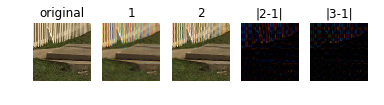

In [10]:
fs = [dm.demosaic_bilinear, dm.demosaic_smooth_hue]
# fs = [lambda x: dm.demosaic_smooth_hue(x,log_space=False), lambda x: dm.demosaic_smooth_hue(x,log_space=True)]
dm.demosaic_compare(kodak[18], fs, crop=crop)

## Median Filter (Freeman)
- review: https://pdfs.semanticscholar.org/28c8/99ab34b6dd91d10474b5635eec6a97b8e3fa.pdf
- patent: https://patents.google.com/patent/US4724395A/en

The algorithm
  - interpolate `G`
  - compute hue for `R`,`B` channels at subsampled locations
  - interpolate hue for all pixels in `R`,`B` channels
  - determine chrominance `R`,`B` from hue

methods:                    1                    2
psnr:                  39.540               39.752
mses:                  52.262               47.392


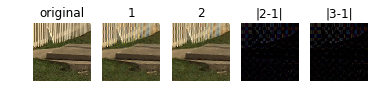

In [11]:
# fs = [dm.demosaic_smooth_hue, dm.demosaic_median_filter]
fs = [lambda x: dm.demosaic_median_filter(x,log_space=False), lambda x: dm.demosaic_median_filter(x,log_space=True)]
dm.demosaic_compare(kodak[18], fs, crop=crop)

## Laplacian-Corrected Interpolation (MATLAB's `demosaic`)
- paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=1326587
- summary: https://www.ipol.im/pub/art/2011/g_mhcd/article.pdf
- matlab `demosaic`: https://stanford.edu/class/ee367/slides/lecture4.pdf

Incorporate second-order derivative as a correction term at interpolated pixels. For example, when interpolating the green channel $G_{i,j}$ at a pixel where the red channel is known $R_{i,j}$, the interpolated value is given by
$$
G_{i,j} = G^{bl}_{i,j} + \alpha \nabla^2 R_{i,j}
$$
where $G^{bl}_{i,j}$ is bilinearly interpolated pixel, $\nabla^2 R_{i,j}$ is the discrete laplacian, $\alpha$ is the gain factor that controls the intensity of laplacian correction. Similarly, to estimate red channels $R_{i,j}$ at at green and blue pixels
$$
R_{i,j} = R^{bl}_{i,j} + \beta \nabla^2 G_{i,j}
$$
$$
R_{i,j} = R^{bl}_{i,j} + \gamma \nabla^2 B_{i,j}
$$
The blue channel are estimated similarly to above. For Kodak dataset
$$
\alpha=\frac{1}{2} \quad \beta = \frac{5}{8} \quad \gamma= \frac{3}{4}
$$
Implementation-wise, we have 3 unique filters 

methods:                    1                    2
psnr:                  38.146               39.864
mses:                  99.313               45.019


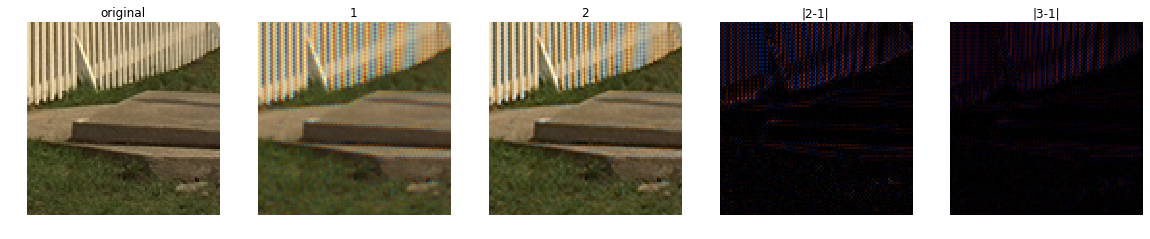

In [14]:
fs = [dm.demosaic_bilinear, dm.demosaic_laplacian_corrected]
dm.demosaic_compare(kodak[18], fs, crop=crop)